# Erste deskriptive Analysen für aggregierte Daten

### Datenimport

Importieren und Zusammenfügen der aggregierten Daten von https://www.ckw.ch/lp/opendata.html 

Aggregierte Daten: Summierter Verbrauch pro Zeitfenster pro Gemeinde

In [195]:
%reset

In [196]:
# Verwendete Packages:

import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
import datetime
import ics
from ics import Calendar
import calendar
from urllib.request import urlopen
from csv_ical import Convert
from dateutil import parser
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm

In [197]:
# Datenimport 2022

dfs22 = {} 
for i in range(202201, 202211):   
    def loadData(month : int = i) -> pd.core.frame.DataFrame :
        url = "https://axsa4prod4publicdata4sa.blob.core.windows.net/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
        return pd.read_csv(url)
    datasetname = i 
    dfs22["dataset{0}".format(i)] = loadData()

In [198]:
# Datenimport 2021

dfs21 = {}
for i in range(202101, 202113):   
    def loadData(month : int = i) -> pd.core.frame.DataFrame :
        url = "https://axsa4prod4publicdata4sa.blob.core.windows.net/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
        return pd.read_csv(url)
    datasetname = i 
    dfs21["dataset{0}".format(i)] = loadData()

In [199]:
# Zusammenfügen

df_data = pd.DataFrame()
df_data = pd.concat([
    dfs22['dataset202201'],
    dfs22['dataset202202'], 
    dfs22['dataset202203'], 
    dfs22['dataset202204'], 
    dfs22['dataset202205'], 
    dfs22['dataset202206'], 
    dfs22['dataset202207'], 
    dfs22['dataset202208'],
    dfs22['dataset202209'],
    dfs22['dataset202210'],
    dfs21['dataset202101'],
    dfs21['dataset202102'], 
    dfs21['dataset202103'], 
    dfs21['dataset202104'], 
    dfs21['dataset202105'], 
    dfs21['dataset202106'], 
    dfs21['dataset202107'], 
    dfs21['dataset202108'],
    dfs21['dataset202109'],
    dfs21['dataset202110'],
    dfs21['dataset202111'],
    dfs21['dataset202112']
], ignore_index=True,axis=0)
df_data
df_data.to_pickle("Dataset.pkl") # Zwischenspeicherung Datenset

### Datenaufbereitung

In [200]:
df_data = pd.read_pickle("Dataset.pkl")

In [201]:
# Formatierung von "timestamp"

df_data['timestamp'] = pd.to_datetime(df_data['timestamp']).dt.tz_convert('Europe/Berlin') # Anpassung Zeitzone auf CET
df_data['timestamp'] = pd.to_datetime(df_data['timestamp'], format="%Y-%m-%dT%H:%M:%S.%fZ", errors = 'coerce') # Formatierung

In [202]:
# Datum-Variablen

df_data['date'] = df_data['timestamp'].dt.date # Datum
df_data["date"] = pd.to_datetime(df_data["date"], format='%Y-%m-%d') # Formatierung Datum
df_data['month'] = df_data['timestamp'].dt.month # Monat
df_data['year'] = df_data['timestamp'].dt.year # Jahr
df_data['timestamp'] = df_data['timestamp'].dt.time # Uhrzeit
df_data['timestamp'] = pd.to_datetime(df_data['timestamp'], format='%H:%M:%S') # Formatierung Uhrzeit
df_data = df_data[~(df_data["year"]=="2020")] # Löschen der (vereinzelten) Werte aus 2020

In [203]:
print(df_data)
df_data.dtypes
df_data.to_pickle("Dataset.pkl") # Zwischenspeicherung Datenset

         area_code           timestamp  num_meter   value_kwh       date  \
0             6028 1900-01-01 12:30:00        131   23.682353 2022-01-28   
1             6028 1900-01-01 22:45:00        130   22.985000 2022-01-20   
2             6028 1900-01-01 14:30:00        130   24.486000 2022-01-04   
3             6028 1900-01-01 13:15:00        131   32.138353 2022-01-27   
4             6028 1900-01-01 10:45:00        130   37.359000 2022-01-14   
...            ...                 ...        ...         ...        ...   
7206399       6263 1900-01-01 19:30:00        442   93.188000 2021-12-14   
7206400       6263 1900-01-01 03:45:00        440  152.357000 2021-12-11   
7206401       6263 1900-01-01 11:30:00        440  104.941000 2021-12-10   
7206402       6263 1900-01-01 03:00:00        440  184.617000 2021-12-10   
7206403       6263 1900-01-01 11:30:00        441   82.090000 2021-12-27   

         month  year  
0            1  2022  
1            1  2022  
2            1  20

#### Zusammmenführen mit Gemeindegrössen

Öffentliche Einwohnerzahlen pro PLZ <br>
   * anzahl: Anzahl Einwohner pro PLZ per Stichtag 1.11.2022  <br>
   * typ: m=männlich, w=weiblich, f=firma

In [204]:
# Import öffentlicher Einwohnerzahlen pro PLZ

df_data = pd.read_pickle("Dataset.pkl")   
df_pop = pd.read_csv('https://swisspost.opendatasoft.com/api/v2/catalog/datasets/bevoelkerung_proplz/exports/csv', delimiter= ';')
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9552 entries, 0 to 9551
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   stichdatum  9552 non-null   object 
 1   plz         9549 non-null   float64
 2   anzahl      9552 non-null   int64  
 3   typ         9552 non-null   object 
 4   ortbez18    9546 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 373.2+ KB


In [205]:
# Zusammenführen mit Verbrauchsdaten

df_pop.rename(columns={'plz':'area_code'}, inplace=True) # Umbenennen PLZ-Spalte
df_data = pd.merge(df_data, df_pop, how="left", on=["area_code"]) # Left-join

In [206]:
# Reshape & Bereinigung 

df_data=df_data.pivot(index=['area_code', 'timestamp', 'num_meter', 'value_kwh', 'stichdatum', 'ortbez18', 'date', 'year', 'month'], \
columns='typ', values=['anzahl']).reset_index() # Typ-Kategorien von long- in shor-Format

df_data['num_habits']=df_data['anzahl','f'] + df_data['anzahl','m'] + df_data['anzahl','w'] # Berechnung Anzahl Einwohner pro Gemeinde
df_data.columns = df_data.columns.droplevel('typ') # Löschen Index-Hierarchie
del df_data['stichdatum'] # Löschen col Stichdatum
df_data.columns.values[8:11] =['num_f', 'num_m', 'num_w' ] # Umbenennen Variablen


In [207]:
df_data.to_pickle("Dataset01.pkl") # Zwischenspeicherung Datenset
df_data

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,num_w,num_habits
0,4806,1900-01-01 00:00:00,19,4.45000,Wikon,2021-01-01,2021,1,124,804,779,1707
1,4806,1900-01-01 00:00:00,24,4.69300,Wikon,2021-01-25,2021,1,124,804,779,1707
2,4806,1900-01-01 00:00:00,24,4.78400,Wikon,2021-01-22,2021,1,124,804,779,1707
3,4806,1900-01-01 00:00:00,24,4.92200,Wikon,2021-01-08,2021,1,124,804,779,1707
4,4806,1900-01-01 00:00:00,24,5.08800,Wikon,2021-01-26,2021,1,124,804,779,1707
...,...,...,...,...,...,...,...,...,...,...,...,...
7206399,6344,1900-01-01 23:45:00,925,161.78300,Meierskappel,2022-04-25,2022,4,220,947,907,2074
7206400,6344,1900-01-01 23:45:00,926,151.60475,Meierskappel,2022-09-26,2022,9,220,947,907,2074
7206401,6344,1900-01-01 23:45:00,928,96.54700,Meierskappel,2022-09-01,2022,9,220,947,907,2074
7206402,6344,1900-01-01 23:45:00,928,97.69100,Meierskappel,2022-06-30,2022,6,220,947,907,2074


#### Import öffentlicher Wetterdaten 
* tre200d0 = °C Lufttemperatur 2 m über Boden; Tagesmittel
* prestad0 = hPa Luftdruck auf Stationshöhe (QFE); Tagesmittel
    

In [208]:
# Import Daten 2022

df_data = pd.read_pickle("Dataset01.pkl")
df_temp22= pd.read_csv('https://data.geo.admin.ch/ch.meteoschweiz.klima/nbcn-tageswerte/nbcn-daily_LUZ_current.csv', delimiter= ';') 
df_temp22=df_temp22[['tre200d0', 'prestad0', 'station/location', 'date']]
df_temp22["date"] = pd.to_datetime(df_temp22["date"], format='%Y%m%d')
df_temp22.rename(columns={'tre200d0':'daytemp','prestad0': "airpress"}, inplace=True)


In [209]:
# Import Daten 2021

df_temp21= pd.read_csv('https://data.geo.admin.ch/ch.meteoschweiz.klima/nbcn-tageswerte/nbcn-daily_LUZ_previous.csv', delimiter= ';') # 2021
df_temp21=df_temp21[['tre200d0', 'prestad0', 'station/location', 'date']]
df_temp21["date"] = pd.to_datetime(df_temp21["date"], format='%Y%m%d')
df_temp21.rename(columns={'tre200d0':'daytemp','prestad0': "airpress"}, inplace=True)

In [210]:
# Zusammenführen mit Verbrauchsdaten

df_temp = pd.concat([df_temp22, df_temp21], ignore_index=True,axis=0) # Zusammenfügen Wetterdaten 2021 & 2022
df_data = pd.merge(df_data, df_temp, how="left", on=["date"]) # Merge mit Verbrauchsdaten
df_data
df_data.to_pickle("Dataset02.pkl") # Zwischenspeicherung Datenset

#### Import Daten zum Smart Meter Rollout

In [211]:
df_data = pd.read_pickle("Dataset02.pkl")

In [212]:
# Auszug von Gemeinde- und PLZ-Daten

df_areas=df_data.sort_values('ortbez18', ascending=False).groupby('area_code').head(1)
df_areas =  df_areas[["area_code", "ortbez18"]]
df_areas=pd.DataFrame(df_areas)
df_areas.to_excel(r'C:\Users\ckw-stea\Desktop\Python\Gemeinden_SM.xlsx', index=False)

In [213]:
# Import Daten zum Smart Meter Rollout 

df_SM = pd.read_excel(r'C:\Users\ckw-stea\Desktop\Python\SM Rollout.xlsx') # Import Daten
df_SM.rename({"PLZ": "area_code"}, axis=1, inplace=True) # Umbenennen PLZ-Spalte
df_data = pd.merge(df_data, df_SM, how="left", on=["area_code"]) # Merge mit Verbrauchsdaten

#### Zusätzliche Variablen

In [214]:
#Durchschnittlicher Verbrauch pro Smart Meter pro Gemeinde

df_data['kwh_permeterarea'] = df_data['value_kwh']/df_data['num_meter']

In [215]:
# Durchschnittlicher Verbrauch pro Smart Meter pro 15-min-Zeitfenster

df_data['kwh_perdatetime']=df_data.groupby(['date', 'timestamp'])['value_kwh'].transform('sum') # Total kwh pro Timeframe über alle Gemeinden
df_data['sm_perdatetime']=df_data.groupby(['date', 'timestamp'])['num_meter'].transform('sum') # Anzahl Smart Meter pro Timeframe über alle Gemeinden 
df_data['kwh_persmdt']=df_data['kwh_perdatetime']/df_data['sm_perdatetime'] # kwh pro Timeframe pro Smart Meter


In [216]:
# Ergänzung Saison 

df_data.loc[(df_data['month'] == 12) | (df_data['month'] == 1) | (df_data['month'] == 2) , 'season'] = 'Winter' # Neue Spalte mit "Winter" für Wintermonate
df_data.loc[(df_data['month'] == 3) | (df_data['month'] == 4) | (df_data['month'] == 5) , 'season'] = 'Frühling' # "Frühling" für Frühlingsmonate
df_data.loc[(df_data['month'] == 6) | (df_data['month'] == 7) | (df_data['month'] == 8) , 'season'] = 'Sommer' # "Sommer" für Sommermonate
df_data.loc[(df_data['month'] == 9) | (df_data['month'] == 10) | (df_data['month'] == 11) , 'season'] = 'Herbst' # "Herbst" für Herbstmonate

In [217]:
 # Hinzufügen Wochentag

df_data['weekday']= df_data['date'].dt.day_name()

In [218]:
df_data.to_pickle("Dataset03.pkl") # Zwischenspeicherung Datenset
df_data.sort_values(['date', 'timestamp'])

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,...,airpress,station/location,Start Rollout,Ende Rollout,kwh_permeterarea,kwh_perdatetime,sm_perdatetime,kwh_persmdt,season,weekday
0,4806,1900-01-01 00:00:00,19,4.450000,Wikon,2021-01-01,2021,1,124,804,...,953.9,LUZ,2021-03-26,2021-03-31,0.234211,13521.100398,38951,0.347131,Winter,Friday
183333,6005,1900-01-01 00:00:00,112,25.415000,St. Niklausen LU/Luzern,2021-01-01,2021,1,3192,12599,...,953.9,LUZ,2023-08-01,2023-08-27,0.226920,13521.100398,38951,0.347131,Winter,Friday
246813,6010,1900-01-01 00:00:00,93,11.088188,Kriens/Pilatus Kulm,2021-01-01,2021,1,2535,14560,...,953.9,LUZ,2023-05-25,2023-07-31,0.119228,13521.100398,38951,0.347131,Winter,Friday
246814,6010,1900-01-01 00:00:00,1707,199.815000,Kriens/Pilatus Kulm,2021-01-01,2021,1,2535,14560,...,953.9,LUZ,2023-05-25,2023-07-31,0.117056,13521.100398,38951,0.347131,Winter,Friday
310364,6014,1900-01-01 00:00:00,27,10.531000,Luzern,2021-01-01,2021,1,1263,5774,...,953.9,LUZ,2023-03-27,2023-03-28,0.390037,13521.100398,38951,0.347131,Winter,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760040,6182,1900-01-01 09:30:00,26,2.310000,Escholzmatt,2022-10-24,2022,10,244,1512,...,964.8,LUZ,2014-01-01,2014-05-01,0.088846,8.410000,131,0.064198,Herbst,Monday
6682953,6284,1900-01-01 09:30:00,16,1.170000,Gelfingen/Sulz LU,2022-10-24,2022,10,96,708,...,964.8,LUZ,2021-06-01,2021-06-11,0.073125,8.410000,131,0.064198,Herbst,Monday
1209639,6030,1900-01-01 09:45:00,15,0.610000,Ebikon,2022-10-24,2022,10,1442,8323,...,964.8,LUZ,2021-09-14,2021-12-06,0.040667,1.240000,26,0.047692,Herbst,Monday
1273134,6032,1900-01-01 09:45:00,11,0.630000,Emmen,2022-10-24,2022,10,789,4425,...,964.8,LUZ,2023-01-30,2023-03-26,0.057273,1.240000,26,0.047692,Herbst,Monday


#### Ergänzung von Feiertagen und Ferien

In [219]:
df_data = pd.read_pickle("Dataset03.pkl")

In [220]:
# Import Schulferien-Kalender Kanton Luzern 2021

url = 'https://www.schulferien.org/media/ical/schweiz/ferien_luzern_alle-schulen_2021.ics?k=X1-tbnx2FDD-JES_XUvgkPZvrwnD_7Eg5QILxcWCnN54JcWmszYrnbbROEQwNAlSBe75Tf5i_KEDZXYEyFPYdb2vr5HYCo3dpCMfIHMmWig' 

icsFile = ics.Calendar(urlopen(url).read().decode('iso-8859-1'))
events = icsFile.events

In [221]:
# Import Schulferien-Kalender Kanton Luzern 2022

url = 'https://www.schulferien.org/media/ical/schweiz/ferien_luzern_alle-schulen_2022.ics?k=-HeiXBRn4cEMJC0g6GpsW4cwS7i_b0Hs7tsswy8bHRUVop65bjCsQJsMkxQUCgPrygs9IZeQTkvkKG_P4z_xNkk6Fg0PXj9nDQ7H-z__IKE'

icsFile = ics.Calendar(urlopen(url).read().decode('iso-8859-1'))
school22 = icsFile.events
events.update(school22) # Hinzufügen zu Events
events

{<all-day Event 'Sportferien 2021 Luzern' begin:2021-02-06 end:2021-02-22>,
 <all-day Event 'FrÃ¼hlingsferien 2021 Luzern' begin:2021-04-02 end:2021-04-19>,
 <all-day Event 'Sommerferien 2021 Luzern' begin:2021-07-10 end:2021-08-23>,
 <all-day Event 'Herbstferien 2021 Luzern' begin:2021-10-02 end:2021-10-18>,
 <all-day Event 'Weihnachtsferien 2021 Luzern' begin:2021-12-18 end:2022-01-03>,
 <all-day Event 'Sportferien 2022 Luzern' begin:2022-02-19 end:2022-03-07>,
 <all-day Event 'FrÃ¼hlingsferien 2022 Luzern' begin:2022-04-15 end:2022-05-02>,
 <all-day Event 'Sommerferien 2022 Luzern' begin:2022-07-09 end:2022-08-22>,
 <all-day Event 'Herbstferien 2022 Luzern' begin:2022-10-01 end:2022-10-17>,
 <all-day Event 'Weihnachtsferien 2022 Luzern' begin:2022-12-09 end:2022-12-10>,
 <all-day Event 'Weihnachtsferien 2022 Luzern' begin:2022-12-24 end:2023-01-09>}

In [222]:
# Ergänzung Ferien im Datenset

holidayCheck = []
for _datetime in df_data['date']:

    dfDate = int(_datetime.strftime('%Y%m%d')) # Datetime-Variable "date" in String konvertieren
    
    check = False
    for event in events: 
        eventStart = int(event.begin.strftime('%Y%m%d')) # Event-Startdatum in String konvertieren
        eventEnd = int(event.end.strftime('%Y%m%d')) # Event-Enddatum in String konvertieren

        if (dfDate >= eventStart) and (dfDate < eventEnd) : # Check für jedes Datum, ob von Ferien- oder Feiertag betroffen
            holidayCheck.append(1)
            check = True
            break
        else:
            check = False
            
    if check == False:
        holidayCheck.append(0)

df_data = df_data.assign(schoolhol = holidayCheck) # Neue Spalte mit Ferienindikator

In [223]:
# Import Feiertagskalender Kanton Luzern 2021

url = 'https://www.schulferien.org/media/ical/schweiz/feiertage_luzern_2021.ics?k=6LaiL2FVxUpK0nKXOZLWVBXS4KTyruz76LOzri9flPxd5iwVANFz74HoRBUszjAk-JWoWFNCyNqJqdsRaVvo1UUSHV7Ssevj85XsPpCQUtA' 

icsFile = ics.Calendar(urlopen(url).read().decode('iso-8859-1'))
events = icsFile.events

In [224]:
# Import Feiertagskalender Kanton Luzern 2022

url = 'https://www.schulferien.org/media/ical/schweiz/feiertage_luzern_2022.ics?k=Lmxggzt9kYC0jKx4fu-BijSs_RyNiOdPeXaG-ag_QdWyJloVtnoqL_0w80bdIeZ2SU2DOGB9gOr3ATat4H1IBAa1Ffa0y89pEnD_iYnopgo' 

icsFile = ics.Calendar(urlopen(url).read().decode('iso-8859-1'))
holidays22 = icsFile.events
events.update(holidays22) # Hinzufügen zu Events
events

{<all-day Event 'Neujahr' begin:2021-01-01 end:2021-01-02>,
 <all-day Event 'Josefstag' begin:2021-03-19 end:2021-03-20>,
 <all-day Event 'Karfreitag' begin:2021-04-02 end:2021-04-03>,
 <all-day Event 'Ostermontag' begin:2021-04-05 end:2021-04-06>,
 <all-day Event 'Auffahrt' begin:2021-05-13 end:2021-05-14>,
 <all-day Event 'Pfingstmontag' begin:2021-05-24 end:2021-05-25>,
 <all-day Event 'Fronleichnam' begin:2021-06-03 end:2021-06-04>,
 <all-day Event 'Peter und Paul' begin:2021-06-29 end:2021-06-30>,
 <all-day Event 'Nationalfeiertag' begin:2021-08-01 end:2021-08-02>,
 <all-day Event 'Eidg. Dank-\, Buss- und Bettag' begin:2021-09-19 end:2021-09-20>,
 <all-day Event 'Allerheiligen' begin:2021-11-01 end:2021-11-02>,
 <all-day Event 'MariÃ¤ EmpfÃ¤ngnis' begin:2021-12-08 end:2021-12-09>,
 <all-day Event 'Weihnachten' begin:2021-12-25 end:2021-12-26>,
 <all-day Event 'Stephanstag' begin:2021-12-26 end:2021-12-27>,
 <all-day Event 'Neujahr' begin:2022-01-01 end:2022-01-02>,
 <all-day Event

In [225]:
# Ergänzung Feiertage im Datenset

holidayCheck = []
for _datetime in df_data['date']:

    dfDate = int(_datetime.strftime('%Y%m%d')) # Datetime-Variable "date" in String konvertieren
    
    check = False
    for event in events: 
        eventStart = int(event.begin.strftime('%Y%m%d')) # Event-Startdatum in String konvertieren
        eventEnd = int(event.end.strftime('%Y%m%d')) # Event-Enddatum in String konvertieren

        if (dfDate >= eventStart) and (dfDate < eventEnd) : # Check für jedes Datum, ob von Ferien- oder Feiertag betroffen
            holidayCheck.append(1)
            check = True
            break
        else:
            check = False
            
    if check == False:
        holidayCheck.append(0)

df_data = df_data.assign(holiday = holidayCheck) # Neue Spalte mit Ferien-/Feiertagindikator

In [226]:
df_data.to_pickle("Dataset04.pkl") # Zwischenspeicherung Datenset

In [227]:
df_data

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,...,Start Rollout,Ende Rollout,kwh_permeterarea,kwh_perdatetime,sm_perdatetime,kwh_persmdt,season,weekday,schoolhol,holiday
0,4806,1900-01-01 00:00:00,19,4.45000,Wikon,2021-01-01,2021,1,124,804,...,2021-03-26,2021-03-31,0.234211,13521.100398,38951,0.347131,Winter,Friday,0,1
1,4806,1900-01-01 00:00:00,24,4.69300,Wikon,2021-01-25,2021,1,124,804,...,2021-03-26,2021-03-31,0.195542,10814.948846,47207,0.229096,Winter,Monday,0,0
2,4806,1900-01-01 00:00:00,24,4.78400,Wikon,2021-01-22,2021,1,124,804,...,2021-03-26,2021-03-31,0.199333,9171.829166,42452,0.216052,Winter,Friday,0,0
3,4806,1900-01-01 00:00:00,24,4.92200,Wikon,2021-01-08,2021,1,124,804,...,2021-03-26,2021-03-31,0.205083,10115.856275,40186,0.251726,Winter,Friday,0,0
4,4806,1900-01-01 00:00:00,24,5.08800,Wikon,2021-01-26,2021,1,124,804,...,2021-03-26,2021-03-31,0.212000,11189.340653,45132,0.247925,Winter,Tuesday,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7206399,6344,1900-01-01 23:45:00,925,161.78300,Meierskappel,2022-04-25,2022,4,220,947,...,2021-08-31,2021-09-10,0.174901,14456.019445,104492,0.138346,Frühling,Monday,1,0
7206400,6344,1900-01-01 23:45:00,926,151.60475,Meierskappel,2022-09-26,2022,9,220,947,...,2021-08-31,2021-09-10,0.163720,12604.378570,106231,0.118651,Herbst,Monday,0,0
7206401,6344,1900-01-01 23:45:00,928,96.54700,Meierskappel,2022-09-01,2022,9,220,947,...,2021-08-31,2021-09-10,0.104038,9141.273673,106204,0.086073,Herbst,Thursday,0,0
7206402,6344,1900-01-01 23:45:00,928,97.69100,Meierskappel,2022-06-30,2022,6,220,947,...,2021-08-31,2021-09-10,0.105270,9139.271473,105309,0.086785,Sommer,Thursday,0,0


### Grafiken

In [322]:
df_data = pd.read_pickle("Dataset04.pkl")
sns.set_theme() # definiere Seaborn als Plot-Stil
sns.set(font_scale=1.1) # Anpassung Default-Schriftgrösse

Text(0, 0.5, 'Ø Stromverbrauch pro Smart Meter pro Tag')

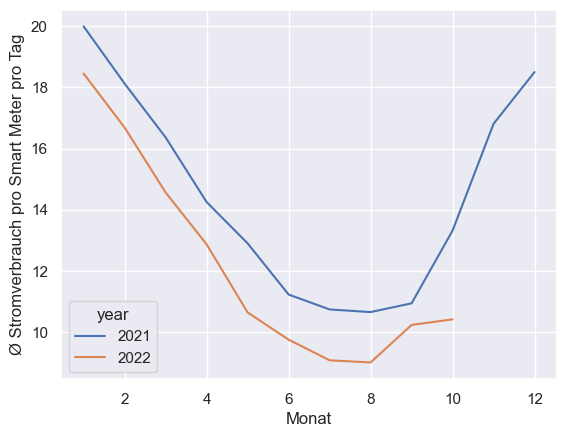

In [229]:
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year','month', 'date'])[['kwh_persmdt']].sum() # Verbrauch pro Smart Meter pro Tag

df_day.pivot_table(values="kwh_persmdt", index="month", columns="year").plot()

plt.xlabel("Monat") # X-Label
plt.ylabel("Ø Stromverbrauch pro Smart Meter pro Tag") # Y-Label

#### Verbrauch pro Smart Meter über Wochentage

In [317]:
df_day

kwh_persmdt
schoolhol weekday               
0         Friday       14.034910
          Monday       13.876592
          Saturday     13.904190
          Sunday       13.480251
          Thursday     13.696745
          Tuesday      13.870995
          Wednesday    13.838410
1         Friday       12.456622
          Monday       12.676523
          Saturday     12.743867
          Sunday       12.347053
          Thursday     12.562972
          Tuesday      12.664493
          Wednesday    12.547447

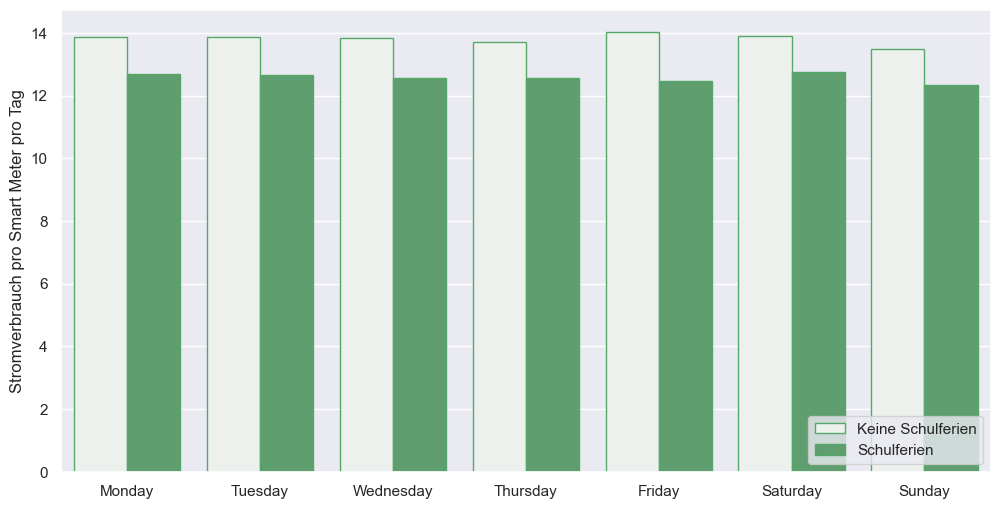

In [354]:
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year','month', 'weekday','schoolhol','date'])[['kwh_persmdt']].sum() # Verbrauch pro Smart Meter pro Tag
df_day=df_day.groupby(['schoolhol','weekday'])[['kwh_persmdt']].mean() # Durchschnittlicher Verbrauch pro Wochentag

df_day = df_day.reset_index() # Index-Hierarchie aufheben
df_day['weekday'] = df_day['weekday'].astype("category") # Kategorie-Typ für Wochentage festlegen
df_day['weekday'] = df_day['weekday'].cat.set_categories(["Monday", "Tuesday", 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True) # Daten nach Wochentagen ordnen

plt.figure(figsize=(12,6))
ax=sns.barplot(x='weekday', y='kwh_persmdt', hue='schoolhol', data=df_day, color = 'g', edgecolor = 'g') 
ax.set(xlabel=None, ylabel="Stromverbrauch pro Smart Meter pro Tag") # X-Label aufheben & Y-Label benennen

labels=["Keine Schulferien","Schulferien"] # Legenden-Labels
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title=None, loc='lower right') # Positionierung Legende

plt.show()

Text(0, 0.5, 'Stromverbrauch pro Smart Meter pro Tag')

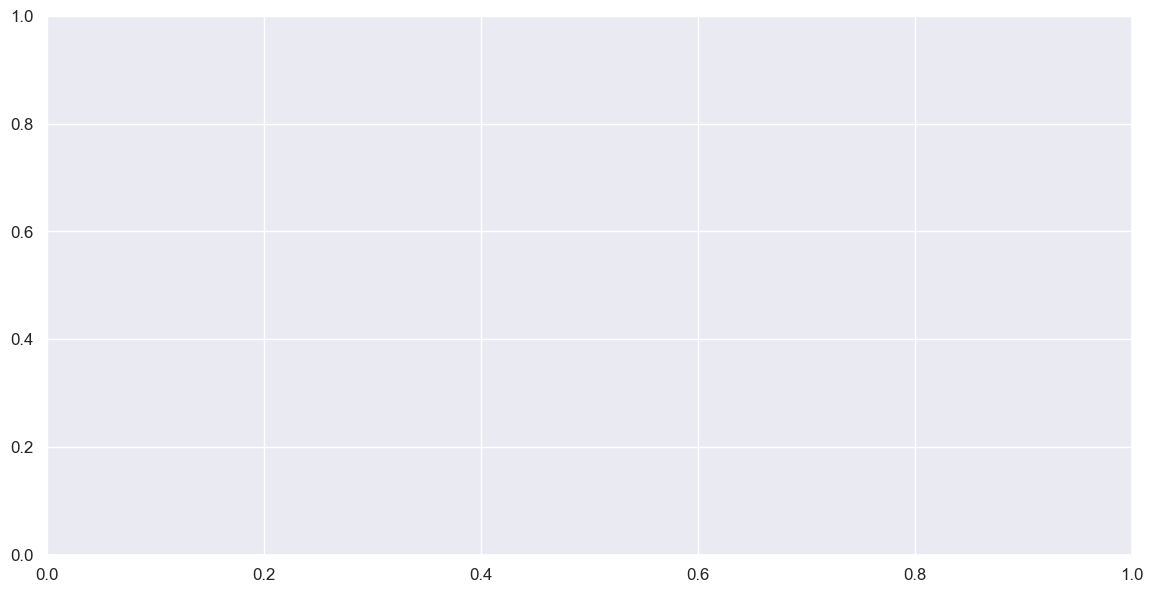

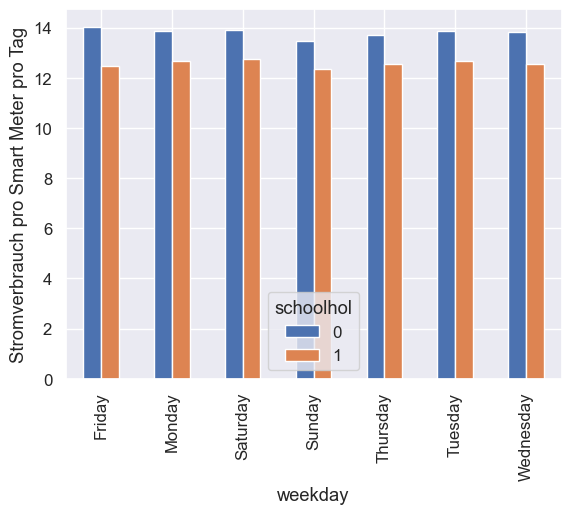

In [315]:



df_day.pivot_table(values="kwh_persmdt", columns='schoolhol', index="weekday").plot(kind='bar')


#### Verbrauch pro Smart Meter über Tageszeit

<function matplotlib.pyplot.show(close=None, block=None)>

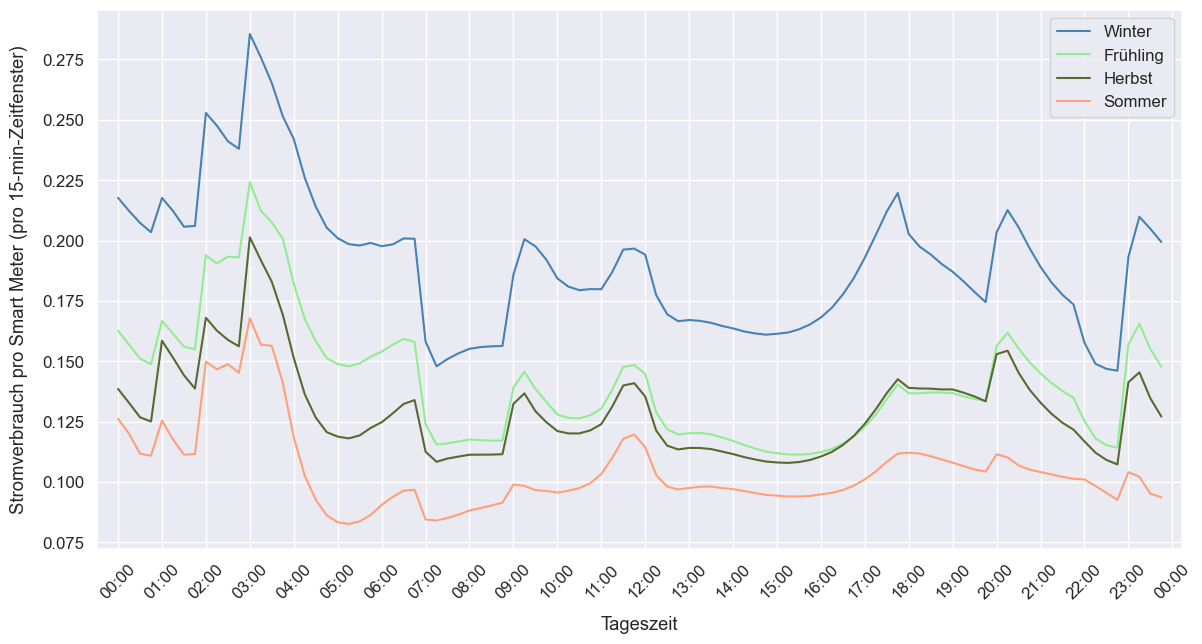

In [310]:
df_time=df_data.pivot_table(values="kwh_persmdt", index="timestamp", columns="season") # Pivot-Tabelle mit durchschnittlichem Verbrauch pro Zeitfenster und Saison

fig, ax = plt.subplots(figsize = (14,7)) # Grafik-Grösse

ax.plot(df_time.index, df_time['Winter'], color = 'steelblue', label='Winter')
ax.plot(df_time.index, df_time['Frühling'], color = 'lightgreen', label='Frühling')
ax.plot(df_time.index, df_time['Herbst'], color = 'darkolivegreen', label='Herbst')
ax.plot(df_time.index, df_time['Sommer'], color = 'lightsalmon', label='Sommer')

plt.xlabel("Tageszeit", labelpad=10) # X-Label
plt.ylabel("Stromverbrauch pro Smart Meter (pro 15-min-Zeitfenster)", labelpad=10) # Y-Label

ax.xaxis.set_major_locator(md.MinuteLocator(byminute = [0, 60])) # Abstand X-Tick-Labels
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M')) # Format X-Tick-Labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45) # Rotation X-Tick-Labels

plt.margins(x=0.02) # Anpassen Seitenrand
ax.legend() # Hinzufügen Legende

plt.show

#### Effekt CH-Nazi-Spiel

In [231]:
gamedate = datetime.datetime(2022, 5, 22) # Datum Nazi-Spiel
weekday = gamedate.strftime('%A') # Wochentag Nazi-Spiel

In [232]:
# Spalte mit Vergleichstagen für Analyse

df_data.loc[(df_data['month'] == gamedate.month) & (df_data['weekday'] ==  weekday) & (df_data['date']!= gamedate) & (df_data['year']==2022) , 'game'] = 'Vergleich 2022' # Markierung gleiche Wochentage im gleichen Monat 2022
df_data.loc[(df_data['month'] == gamedate.month) & (df_data['weekday'] ==  weekday) &  (df_data['year']==2021), 'game'] = 'Vergleich 2021' # Markeitung gleiche Wochentage im gleichen Monat im 2021
df_data.loc[(df_data['date'] == gamedate) , 'game'] = 'Spieltag' # Markierung Datum Nazi-Spiel

In [233]:
time_range = (df_data['timestamp'].dt.hour >= 12) & (df_data['timestamp'].dt.hour <= 22) # Definition Zeitspanne für Visualisierung
df_game = df_data.loc[time_range] # Datenset-Ausschnitt basierend auf Zeitspanne

<function matplotlib.pyplot.show(close=None, block=None)>

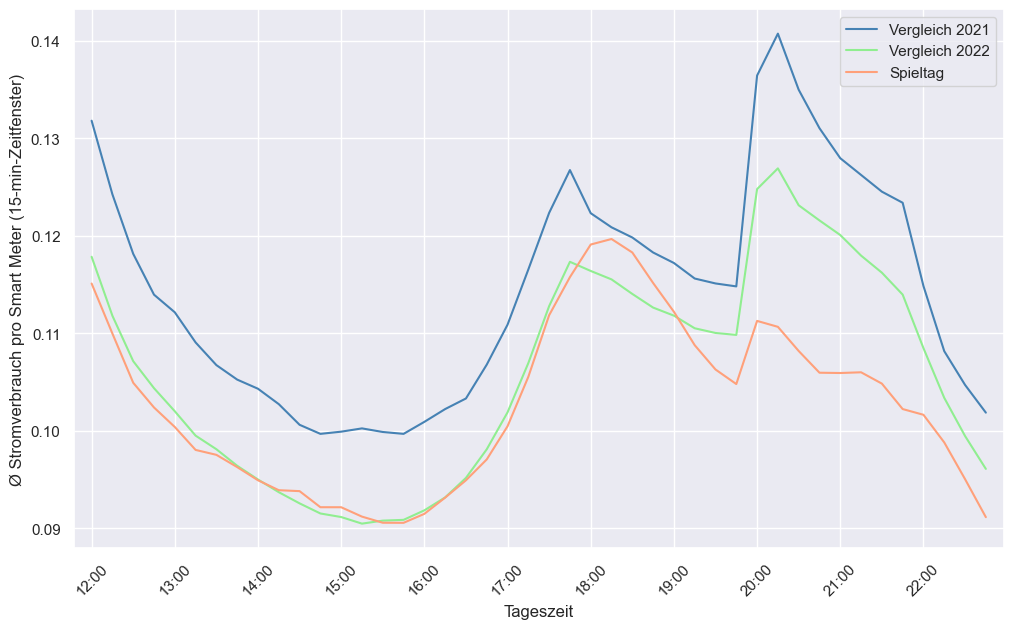

In [234]:
df_game=df_game.pivot_table(values="kwh_persmdt", index="timestamp", columns="game") # Pivot-Tabelle mit durchschnittlichem Verbrauch pro Zeitfenster und Spieltag / Vergleichstage

fig, ax = plt.subplots(figsize = (12,7)) # Grafik-Grösse

ax.plot(df_game.index, df_game['Vergleich 2021'], color = 'steelblue', label='Vergleich 2021')
ax.plot(df_game.index, df_game['Vergleich 2022'], color = 'lightgreen', label='Vergleich 2022')
ax.plot(df_game.index, df_game['Spieltag'], color = 'lightsalmon', label='Spieltag')


plt.xlabel("Tageszeit") # X-Label
plt.ylabel("Stromverbrauch pro Smart Meter (15-min-Zeitfenster)") # Y-Label

ax.xaxis.set_major_locator(md.MinuteLocator(byminute = [0, 60])) # Abstand X-Tick-Labels
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M')) # Format X-Tick-Labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45) # Rotation X-Tick-Labels

plt.margins(x=0.02) # Anpassen Seitenrand
ax.legend() # Hinzufügen Legende

plt.show

In [235]:
df_data = pd.read_pickle("Dataset04.pkl")

#### Durchschnittlicher Verbrauch pro Smart Meter & Tag nach Gemeindegrösse

In [295]:
df_data = pd.read_pickle("Dataset04.pkl") # Neueinlesen Daten 

In [296]:
# Ausschluss PLZ mit Rollout-Ende nach 1.1.2022

df_rollout = df_data[df_data['Ende Rollout'] < datetime.datetime(2022, 1, 1)]
df_rollout.sort_values(by=['Ende Rollout'])

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,...,Start Rollout,Ende Rollout,kwh_permeterarea,kwh_perdatetime,sm_perdatetime,kwh_persmdt,season,weekday,schoolhol,holiday
3623185,6173,1900-01-01 05:45:00,812,130.792000,Flühli LU,2021-05-26,2021,5,135,673,...,2014-01-01,2014-05-01,0.161074,8503.661210,61667,0.137896,Frühling,Wednesday,0,0
3756032,6182,1900-01-01 07:45:00,1607,253.282836,Escholzmatt,2022-01-17,2022,1,244,1512,...,2014-01-01,2014-05-01,0.157612,15166.635380,91468,0.165814,Winter,Monday,0,0
3756033,6182,1900-01-01 07:45:00,1607,265.806836,Escholzmatt,2022-01-24,2022,1,244,1512,...,2014-01-01,2014-05-01,0.165406,15158.384068,92501,0.163873,Winter,Monday,0,0
3756034,6182,1900-01-01 07:45:00,1607,274.227836,Escholzmatt,2022-01-14,2022,1,244,1512,...,2014-01-01,2014-05-01,0.170646,15960.989692,91166,0.175076,Winter,Friday,0,0
3756035,6182,1900-01-01 07:45:00,1607,274.311836,Escholzmatt,2022-01-25,2022,1,244,1512,...,2014-01-01,2014-05-01,0.170698,15401.005712,92820,0.165923,Winter,Tuesday,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226145,6030,1900-01-01 15:45:00,8119,732.661036,Ebikon,2022-09-26,2022,9,1442,8323,...,2021-09-14,2021-12-06,0.090240,10172.567987,106049,0.095923,Herbst,Monday,0,0
1226144,6030,1900-01-01 15:45:00,8117,706.376000,Ebikon,2022-05-31,2022,5,1442,8323,...,2021-09-14,2021-12-06,0.087024,10242.109623,104687,0.097836,Frühling,Tuesday,0,0
1226143,6030,1900-01-01 15:45:00,8117,647.118250,Ebikon,2022-09-01,2022,9,1442,8323,...,2021-09-14,2021-12-06,0.079724,8940.484736,105925,0.084404,Herbst,Thursday,0,0
1226156,6030,1900-01-01 15:45:00,8140,795.277750,Ebikon,2022-09-29,2022,9,1442,8323,...,2021-09-14,2021-12-06,0.097700,11444.144717,106552,0.107404,Herbst,Thursday,0,0


In [297]:
# Ausschluss Verbrauchsdaten vor 1.1.2022

df_rollout = df_rollout[df_data['date'] >= datetime.datetime(2022, 1, 1)]
df_rollout.sort_values(by=['date'])

C:\Users\ckw-stea\AppData\Local\Temp\ipykernel_8104\1121396253.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rollout = df_rollout[df_data['date'] >= datetime.datetime(2022, 1, 1)]


,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,...,Start Rollout,Ende Rollout,kwh_permeterarea,kwh_perdatetime,sm_perdatetime,kwh_persmdt,season,weekday,schoolhol,holiday
3658650,6173,1900-01-01 19:00:00,818,138.692211,Flühli LU,2022-01-01,2022,1,135,673,...,2014-01-01,2014-05-01,0.169550,15032.755838,89992,0.167045,Winter,Saturday,1,1
5791151,6248,1900-01-01 08:15:00,400,37.092000,Alberswil,2022-01-01,2022,1,88,391,...,2021-01-22,2021-01-25,0.092730,10194.651838,89992,0.113284,Winter,Saturday,1,1
2882053,6142,1900-01-01 12:15:00,651,98.674000,Gettnau,2022-01-01,2022,1,106,692,...,2021-01-26,2021-01-28,0.151573,12804.987338,89991,0.142292,Winter,Saturday,1,1
4970575,6221,1900-01-01 11:00:00,1563,211.096000,Rickenbach LU,2022-01-01,2022,1,281,1607,...,2021-04-27,2021-05-05,0.135058,12209.233338,89992,0.135670,Winter,Saturday,1,1
7020143,6289,1900-01-01 21:45:00,584,104.402000,Müswangen/Hämikon,2022-01-01,2022,1,125,658,...,2021-06-02,2021-06-04,0.178771,14325.360721,89992,0.159185,Winter,Saturday,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511389,6036,1900-01-01 03:45:00,844,86.592000,Dierikon,2022-10-24,2022,10,196,920,...,2021-07-14,2021-07-23,0.102597,13455.178000,100320,0.134123,Herbst,Monday,0,0
2267012,6112,1900-01-01 01:30:00,395,104.000000,Doppleschwand,2022-10-24,2022,10,62,464,...,2020-09-09,2020-09-11,0.263291,19498.338000,100392,0.194222,Herbst,Monday,0,0
6288376,6274,1900-01-01 04:15:00,1834,188.070000,Eschenbach LU,2022-10-24,2022,10,440,2144,...,2021-06-29,2021-07-09,0.102546,10305.694000,100307,0.102742,Herbst,Monday,0,0
3933954,6197,1900-01-01 03:15:00,15,1.087000,Schangnau,2022-10-24,2022,10,72,531,...,2014-01-01,2014-05-01,0.072467,10233.985000,100330,0.102003,Herbst,Monday,0,0


In [298]:
df_rollout['kwh_perDay'] = df_rollout.groupby(['area_code', 'date'])['kwh_permeterarea'].transform(np.sum) # Totaler Verbrauch pro Meter pro Datum pro Gemeinde
df_rollout['mean_perArea_perDay'] = df_rollout.groupby(['area_code'])['kwh_perDay'].transform(np.mean) # durchschnittlicher Verbrauch pro Meter pro Tag pro Gemeinde 2022

Text(0, 0.5, 'Stromverbrauch pro Smart Meter pro Tag 2022')

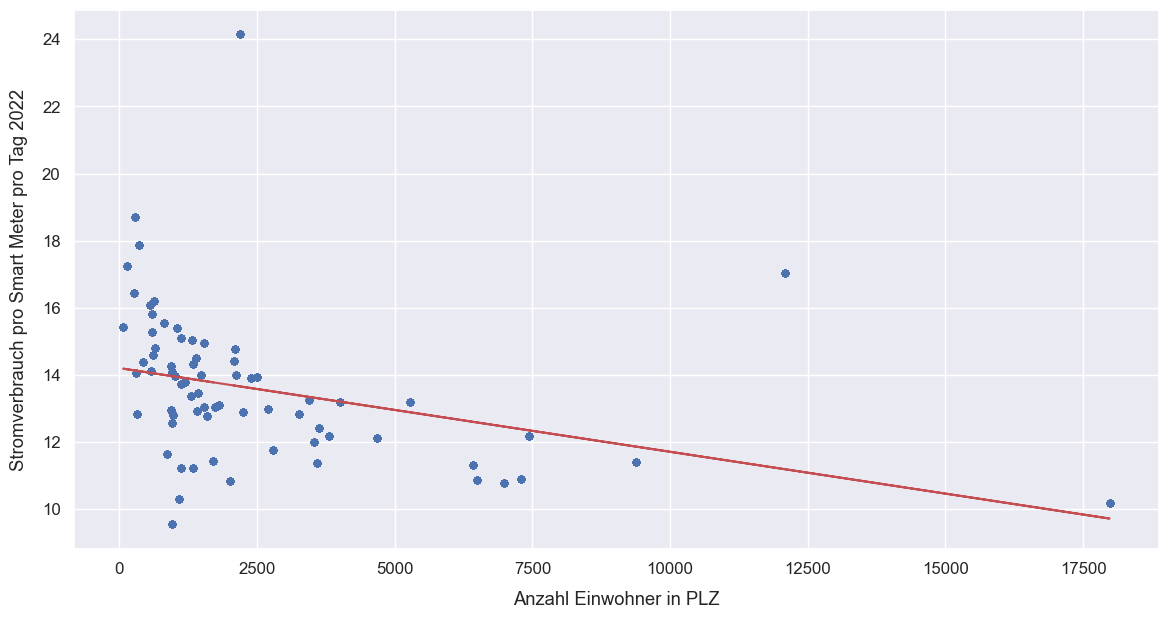

In [311]:
df_rollout.plot.scatter(x = "num_habits", y = 'mean_perArea_perDay', figsize = (14, 7)) # Scatterplot Gemeindegrösse & Verbrauch pro Smart Meter pro Tag 

m, b = np.polyfit(df_rollout["num_habits"], df_rollout["mean_perArea_perDay"], 1) # Korrelationsgerade; m = slope, b=intercept
plt.plot(df_rollout["num_habits"], m*df_rollout["num_habits"] + b, color="r") # Hinzufügen Korrelation zu Grafik

plt.xlabel("Anzahl Einwohner in PLZ",  labelpad=10) # Umbenennen X-Achse
plt.ylabel("Stromverbrauch pro Smart Meter pro Tag 2022",  labelpad=10) # Umbenennen Y-Achse

#### Top 10 / Bottom 10 Gemeinden

In [245]:
df_area=df_rollout.groupby(['area_code', 'ortbez18', 'num_habits'])[['kwh_perDay']].mean() # Durchschnittlicher Tagesverbrauch pro Gemeinde 2022
print(df_area.nlargest(10, 'kwh_perDay')) # Top 10
print(df_area.nsmallest(10, 'kwh_perDay')) # Bottom 10

                                      kwh_perDay
area_code ortbez18        num_habits            
6133      Hergiswil LU    2187         24.145436
6028      Herlisberg      288          18.710399
6114      Steinhuserberg  362          17.869607
6132      Rohrmatt        139          17.245505
6280      Hochdorf/Urswil 12078        17.025779
6126      Daiwil          273          16.443661
6113      Romoos          626          16.210831
6019      Sigigen         560          16.091285
6125      Menzberg        601          15.808981
6145      Fischbach LU    806          15.550578
                                                              kwh_perDay
area_code ortbez18                                num_habits            
6035      Perlen                                  955           9.544681
6030      Ebikon                                  17978        10.191236
4915      St. Urban                               1088         10.314788
6033      Buchrain                             

#### Temperatur und Verbrauch

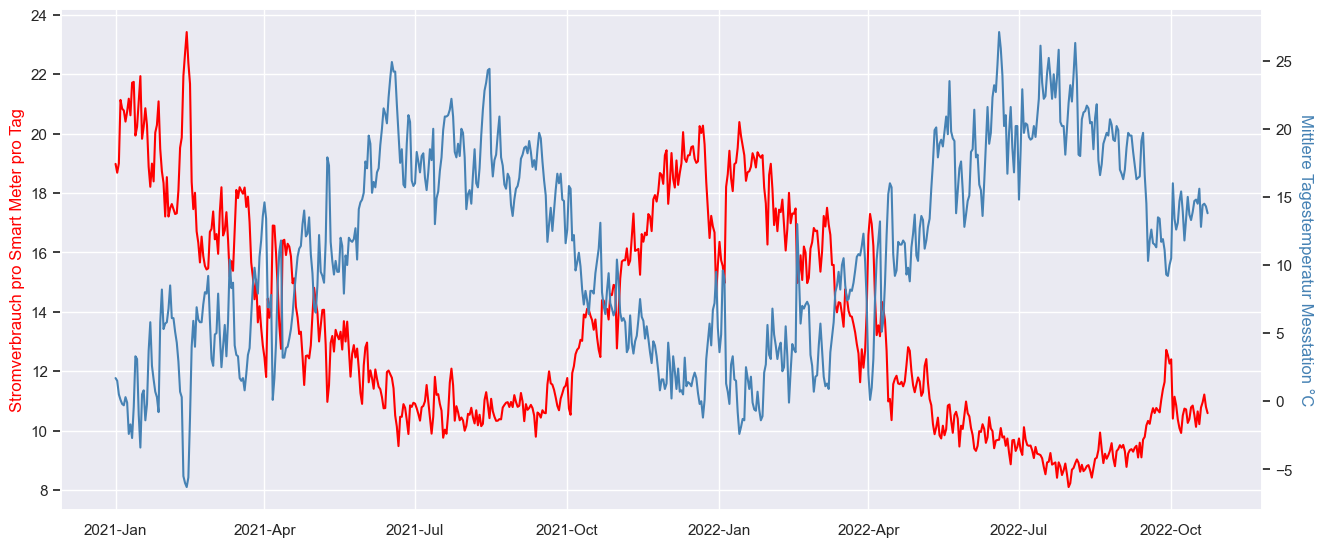

In [302]:
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year','month', 'date', 'daytemp'])[['kwh_persmdt']].sum() # Verbrauch pro Smart Meter pro Tag über alle Gemeinden
df_day = df_day.reset_index() # Index-Hierarchie aufheben
df_day = df_day[df_day['date'] < datetime.datetime(2022, 10, 24)] # Auschluss von letztem, unvollständigen Tag in Datenset

col1 = 'red' # Farben definieren
col2 = 'steelblue'

fig,ax = plt.subplots() # Subplots definieren
fig.set_size_inches(15.5, 6.5)

ax.plot(df_day.date, df_day.kwh_persmdt, color=col1) # Verbrauch zum Plot hinzufügen
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%b')) # Format X-Tick-Labels

#ax.set_xlabel('Jahr-Monat', fontsize=12) # X-Achsen-Beschriftung
ax.set_ylabel('Stromverbrauch pro Smart Meter pro Tag', color=col1, fontsize=12) # Y-Achsen-Beschriftung

ax2 = ax.twinx() # zweite Achse definieren
ax2.plot(df_day.date, df_day.daytemp, color=col2) # Temperatur zum Plot hinzufügen
ax2.set_ylabel('Mittlere Tagestemperatur Messtation °C', color=col2, fontsize=12, rotation=270, labelpad=15)  # Beschriftung 2. Achse
ax2.grid(False) # keine Hilfslinien für 2. Achse

### Daten-Modellierung OLS

In [ ]:
# Vorbereitung kategoriale Dummy-Variablen 

df_data['hour'] = df_data['timestamp'].dt.hour # Variable für Stunde
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene

df_datashort = pd.get_dummies(data=df_datashort, columns=['hour']) # Dummies für Stunde
df_datashort = pd.get_dummies(data=df_datashort, columns=['weekday']) # Dummies für weekdays
df_datashort = pd.get_dummies(data=df_datashort, columns=['month']) # Dummies für months
df_datashort = pd.get_dummies(data=df_datashort, columns=['year']) # Dummies für years

In [274]:
# Modell für 15 Minuten Intervall mit statsmodels

x = df_datashort[['hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22', 'hour_23','weekday_Saturday','weekday_Sunday', 'daytemp', 'holiday', 'schoolhol', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8','month_9','month_10','month_11','month_12','year_2022']]
y = df_datashort['kwh_persmdt']

x = sm.add_constant(x) # Hinzufügen Konstante
 
model = sm.OLS(y, x).fit(cov_type = "HC0") # OLS mit robusten Standard-Fehlern
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            kwh_persmdt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     8941.
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:33:17   Log-Likelihood:             1.6627e+05
No. Observations:               63489   AIC:                        -3.325e+05
Df Residuals:                   63448   BIC:                        -3.321e+05
Df Model:                          40                                         
Covariance Type:                  HC0                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2233      0.001  

In [ ]:
# Modell für Stromverbrauch pro Stunde

df_data['hour'] = df_data['timestamp'].dt.hour # Variable für Stunde
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Stunde zu aggregieren

df_datashort=df_datashort.groupby(['year','month', 'date', 'hour', 'daytemp', 'holiday', 'schoolhol', 'weekday'])[['kwh_persmdt']].sum() # Verbrauch pro Smart Meter pro Stunde
df_datashort = df_datashort.reset_index() # Index-Hierarchie aufheben


df_datashort = pd.get_dummies(data=df_datashort, columns=['hour']) # Dummies für Stunde
df_datashort = pd.get_dummies(data=df_datashort, columns=['weekday']) # Dummies für weekdays
